# Cross-Database ID Lookup Benchmark

Compare lookup performance across PostgreSQL, MySQL, and Redis for sequential, UUIDv4, UUIDv7, and Snowflake identifiers. Run each cell sequentially, validating the output before moving on.

## Runbook overview
- Provision services with Docker Compose.
- Seed 1M rows per ID strategy.
- Execute 10k random lookups per dataset.
- Capture metrics, visualize, and save to `results.csv`.
- Repeat UUID-only workloads on PostgreSQL 18 to compare UUIDv4 vs UUIDv7.

## Environment checklist
1. From this directory, create the environment with `uv venv .venv`.
2. Activate it via `source .venv/bin/activate`.
3. Install dependencies using `uv pip install -r requirements.txt`.

In [1]:
from pathlib import Path
import sys

venv_path = Path('.venv').resolve()
print(f'Python executable: {sys.executable}')
if venv_path.exists() and (Path(sys.prefix) == venv_path or venv_path in Path(sys.prefix).parents):
    print('Environment check: running inside .venv ✅')
else:
    print('Environment check: please activate the uv-managed .venv before continuing ⚠️')

Python executable: /Users/codefox/workspace/practice_infra_arch/pg_uuid_benchmark/.venv/bin/python
Environment check: running inside .venv ✅


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bench_utils import (
    BenchmarkConfig,
    build_connections,
    bootstrap_mysql,
    bootstrap_postgres,
    fetch_function,
    fetch_mysql,
    fetch_redis,
    measure_operation,
    postgres_uuid_workload,
    results_to_frame,
    seed_mysql,
    seed_postgres,
    seed_redis,
)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

/Users/codefox/workspace/practice_infra_arch/pg_uuid_benchmark/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# DRY-RUN helper: override heavy defaults for interactive iteration
# Set DRY_RUN = False when you want to execute the full benchmark (1M records etc.)
DRY_RUN = False


if DRY_RUN:
    RECORD_COUNT = int(os.getenv('RECORD_COUNT', '10000'))
    LOOKUP_ITERATIONS = int(os.getenv('LOOKUP_ITERATIONS', '1000'))
    BATCH_SIZE = int(os.getenv('BATCH_SIZE', '2000'))
    UUID_WORKLOAD_ROWS = int(os.getenv('UUID_WORKLOAD_ROWS', '20000'))
else:
    RECORD_COUNT = int(os.getenv('RECORD_COUNT', '1000000'))
    LOOKUP_ITERATIONS = int(os.getenv('LOOKUP_ITERATIONS', '10000'))
    BATCH_SIZE = int(os.getenv('BATCH_SIZE', '20000'))
    UUID_WORKLOAD_ROWS = int(os.getenv('UUID_WORKLOAD_ROWS', '200000'))

# Config object used across the notebook
config = BenchmarkConfig(batch_size=BATCH_SIZE, lookup_iterations=LOOKUP_ITERATIONS, seed=42)
print(f'DRY_RUN={DRY_RUN} | Records per table: {RECORD_COUNT:,} | Lookups: {config.lookup_iterations:,} | Batch size: {config.batch_size:,} | UUID rows: {UUID_WORKLOAD_ROWS:,}')

DRY_RUN=False | Records per table: 1,000,000 | Lookups: 10,000 | Batch size: 20,000 | UUID rows: 200,000


## Provision databases
Ensure Docker Desktop is running. The next cell brings up PostgreSQL (x2), MySQL, and Redis using `compose.yaml`.

In [4]:
!docker compose up -d --build --remove-orphans

[+] Running 4/4
 ✔ Container pg-bench-mixed  Running                                       0.0s 
 ✔ Container redis-bench     Running                                       0.0s 
 ✔ Container mysql-bench     Running                                       0.0s 
 ✔ Container pg-bench-uuid   Running                                       0.0s 


## Benchmark configuration
Tweak counts through environment variables (`RECORD_COUNT`, `LOOKUP_ITERATIONS`, `BATCH_SIZE`, `UUID_WORKLOAD_ROWS`) if you need smaller dry runs.

In [5]:
RECORD_COUNT = int(os.getenv('RECORD_COUNT', '1000000'))
LOOKUP_ITERATIONS = int(os.getenv('LOOKUP_ITERATIONS', '10000'))
BATCH_SIZE = int(os.getenv('BATCH_SIZE', '20000'))
UUID_WORKLOAD_ROWS = int(os.getenv('UUID_WORKLOAD_ROWS', '200000'))

config = BenchmarkConfig(batch_size=BATCH_SIZE, lookup_iterations=LOOKUP_ITERATIONS, seed=42)
print(f'Records per table: {RECORD_COUNT:,}')
print(f'Lookup iterations: {config.lookup_iterations:,}')
print(f'Insert batch size: {config.batch_size:,}')
print(f'UUID secondary workload rows: {UUID_WORKLOAD_ROWS:,}')

Records per table: 1,000,000
Lookup iterations: 10,000
Insert batch size: 20,000
UUID secondary workload rows: 200,000


In [6]:
connections = build_connections()
print('Connections established for PostgreSQL (mixed + UUID), MySQL, and Redis.')

Connections established for PostgreSQL (mixed + UUID), MySQL, and Redis.


In [7]:
bootstrap_postgres(connections.pg_mixed)
bootstrap_postgres(connections.pg_uuid)
bootstrap_mysql(connections.mysql)
print('Schemas ensured across PostgreSQL and MySQL instances.')

Schemas ensured across PostgreSQL and MySQL instances.


### Seed PostgreSQL (mixed ID strategies)

In [8]:
pg_mixed_summaries = seed_postgres(connections.pg_mixed, RECORD_COUNT, config)
pg_mixed_summaries

Postgres seed snowflake_test: 100%|██████████| 1000000/1000000 [00:33<00:00, 29946.71it/s]



[InsertSummary(dataset=DatasetInfo(database='postgres', id_type='seq_id', table='seq_id_test', id_column='id', samples=[670488, 116740, 26226, 777573, 288390, 256788, 234054, 146317, 772247, 107474, 709571, 776647, 935519, 571859, 91162, 619177, 442418, 33327, 31245, 98247, 229259, 243963, 529904, 631263, 27825, 588509, 208497, 750801, 681454, 735393, 571413, 439899, 231149, 471030, 617890, 291705, 848750, 911528, 6815, 795668, 844963, 167415, 732053, 443144, 356779, 291370, 163033, 225773, 800582, 352945, 107176, 97252, 398383, 101415, 376418, 888663, 360664, 633053, 277371, 846336, 45562, 765180, 481742, 562276, 130890, 967097, 396923, 82628, 578857, 307420, 869694, 659177, 648565, 928464, 903566, 379202, 605398, 201630, 738798, 72934, 48051, 693385, 238969, 810621, 303446, 83668, 896866, 244099, 908574, 105908, 398592, 291477, 475436, 666564, 874629, 382555, 170556, 388163, 372529, 219685, 702730, 279947, 735912, 982154, 716752, 679515, 74871, 638721, 665823, 179452, 560087, 764545,

### Seed PostgreSQL 18 (UUID-only focus)

**Note:** This cell seeds only UUID tables for PostgreSQL 18. To enable full comparison including `seq_id` and `snowflake`, remove the `include_tables` parameter to seed all tables.

In [9]:
pg_uuid_summaries = seed_postgres(
    connections.pg_uuid,
    RECORD_COUNT,
    config,
    include_tables=['uuid_v4_test', 'uuid_v7_test']
)
pg_uuid_summaries

Postgres seed uuid_v7_test: 100%|██████████| 1000000/1000000 [00:33<00:00, 30041.22it/s]



[InsertSummary(dataset=DatasetInfo(database='postgres', id_type='uuid_v4', table='uuid_v4_test', id_column='id', samples=['daf6dab6-bfa7-4f67-8dd5-476a0613c084', '035615d1-1c5e-4c0e-903e-c969c31e328e', 'f2881756-c226-41b8-9b9d-78bfec3c91f8', '6e7ee74b-b43f-43ed-9d93-ec96f1cfbdac', '206cb781-de49-4392-b668-9da167a2aa2f', 'aef5b5d1-a1cc-4f53-a223-f79202c7d85d', '8d4a459c-94c0-47ff-beed-3094d09f9e0e', '577c2d32-cb9d-40ca-800c-e783096979b2', 'cf14e0a1-bd9e-461b-a434-16bccbbdb16a', 'e6add68a-35a1-4785-aa83-efe46cc9b96b', '8c600a53-a050-4903-a385-ba897ce77454', '0f421889-55fd-4ab0-9671-a69ad86bc7ba', '7452177b-9496-4904-96a0-fff5612c1c06', '804f86b4-c4aa-42db-9caf-f12a08677141', 'e0f38104-67e1-4cb3-9e0c-76739cea4887', '9639d268-e3ac-43d1-a13c-7e4a66d56e80', '27e89276-3a0d-4a32-9e03-9471475186d0', '7ab2c70a-6260-4f01-a334-bc32fdac67c8', 'c801177e-6d58-4cc5-a7c2-cf5a222abc64', '604681f6-0ac8-4fc1-9124-c94873649d41', 'eeef4243-0b4a-4dd7-a34c-47e7086f06d6', '34e11763-5c10-4158-b5a6-21279da8e014'

### Seed MySQL

In [10]:
mysql_summaries = seed_mysql(connections.mysql, RECORD_COUNT, config)
mysql_summaries

MySQL seed uuid_v4_test: 100%|██████████| 1000000/1000000 [01:05<00:00, 15160.60it/s]

MySQL seed uuid_v7_test: 100%|██████████| 1000000/1000000 [00:16<00:00, 61162.51it/s]

MySQL seed snowflake_test: 100%|██████████| 1000000/1000000 [00:08<00:00, 113107.35it/s]


[InsertSummary(dataset=DatasetInfo(database='mysql', id_type='seq_id', table='seq_id_test', id_column='id', samples=[670488, 116740, 26226, 777573, 288390, 256788, 234054, 146317, 772247, 107474, 709571, 776647, 935519, 571859, 91162, 619177, 442418, 33327, 31245, 98247, 229259, 243963, 529904, 631263, 27825, 588509, 208497, 750801, 681454, 735393, 571413, 439899, 231149, 471030, 617890, 291705, 848750, 911528, 6815, 795668, 844963, 167415, 732053, 443144, 356779, 291370, 163033, 225773, 800582, 352945, 107176, 97252, 398383, 101415, 376418, 888663, 360664, 633053, 277371, 846336, 45562, 765180, 481742, 562276, 130890, 967097, 396923, 82628, 578857, 307420, 869694, 659177, 648565, 928464, 903566, 379202, 605398, 201630, 738798, 72934, 48051, 693385, 238969, 810621, 303446, 83668, 896866, 244099, 908574, 105908, 398592, 291477, 475436, 666564, 874629, 382555, 170556, 388163, 372529, 219685, 702730, 279947, 735912, 982154, 716752, 679515, 74871, 638721, 665823, 179452, 560087, 764545, 25

In [11]:
seed_df = pd.DataFrame(
    [
        {
            'database': summary.dataset.database,
            'id_type': summary.dataset.id_type,
            'rows_inserted': summary.rows_inserted,
            'duration_s': summary.duration_s,
            'rows_per_second': summary.rows_inserted / max(summary.duration_s, 1e-9),
        }
        for summary in (pg_mixed_summaries + pg_uuid_summaries + mysql_summaries)
    ]
)
seed_df.sort_values(['database', 'id_type']).reset_index(drop=True)

database    id_type  rows_inserted  duration_s  rows_per_second
0     mysql     seq_id        1000000    6.546297    152758.106828
1     mysql  snowflake        1000000    8.842372    113091.828628
2     mysql    uuid_v4        1000000   65.961092     15160.452391
3     mysql    uuid_v7        1000000   16.352502     61152.723017
4  postgres     seq_id        1000000   29.258335     34178.294592
5  postgres  snowflake        1000000   33.397994     29941.918479
6  postgres    uuid_v4        1000000   36.954777     27060.100992
7  postgres    uuid_v4        1000000   36.299577     27548.530260
8  postgres    uuid_v7        1000000   30.397566     32897.371202
9  postgres    uuid_v7        1000000   33.289047     30039.911138

### Prepare Redis keyspace (mirrors PostgreSQL IDs)

In [12]:
redis_datasets = seed_redis(connections.redis, [s.dataset for s in pg_mixed_summaries], config)
redis_datasets

Redis load seq_id: 100%|██████████| 10000/10000 [00:00<00:00, 609159.09it/s]


Redis load snowflake: 100%|██████████| 10000/10000 [00:00<00:00, 1028066.08it/s]


[DatasetInfo(database='redis', id_type='seq_id', table='', id_column='key', samples=['seq_id:670488', 'seq_id:116740', 'seq_id:26226', 'seq_id:777573', 'seq_id:288390', 'seq_id:256788', 'seq_id:234054', 'seq_id:146317', 'seq_id:772247', 'seq_id:107474', 'seq_id:709571', 'seq_id:776647', 'seq_id:935519', 'seq_id:571859', 'seq_id:91162', 'seq_id:619177', 'seq_id:442418', 'seq_id:33327', 'seq_id:31245', 'seq_id:98247', 'seq_id:229259', 'seq_id:243963', 'seq_id:529904', 'seq_id:631263', 'seq_id:27825', 'seq_id:588509', 'seq_id:208497', 'seq_id:750801', 'seq_id:681454', 'seq_id:735393', 'seq_id:571413', 'seq_id:439899', 'seq_id:231149', 'seq_id:471030', 'seq_id:617890', 'seq_id:291705', 'seq_id:848750', 'seq_id:911528', 'seq_id:6815', 'seq_id:795668', 'seq_id:844963', 'seq_id:167415', 'seq_id:732053', 'seq_id:443144', 'seq_id:356779', 'seq_id:291370', 'seq_id:163033', 'seq_id:225773', 'seq_id:800582', 'seq_id:352945', 'seq_id:107176', 'seq_id:97252', 'seq_id:398383', 'seq_id:101415', 'seq_i

## Lookup benchmarks

In [13]:
lookup_jobs = []

for summary in pg_mixed_summaries:
    dataset = summary.dataset
    fetcher = fetch_function(connections.pg_mixed, dataset.table, dataset.id_column)
    lookup_jobs.append(
        (
            f'postgres_mixed::{dataset.id_type}::lookup',
            fetcher,
            list(dataset.samples)[: config.lookup_iterations],
        )
    )

for summary in pg_uuid_summaries:
    dataset = summary.dataset
    fetcher = fetch_function(connections.pg_uuid, dataset.table, dataset.id_column)
    lookup_jobs.append(
        (
            f'postgres_uuid18::{dataset.id_type}::lookup',
            fetcher,
            list(dataset.samples)[: config.lookup_iterations],
        )
    )

for summary in mysql_summaries:
    dataset = summary.dataset
    fetcher = fetch_mysql(connections.mysql, dataset.table, dataset.id_column)
    lookup_jobs.append(
        (
            f'mysql::{dataset.id_type}::lookup',
            fetcher,
            list(dataset.samples)[: config.lookup_iterations],
        )
    )

redis_fetcher = fetch_redis(connections.redis)
for dataset in redis_datasets:
    lookup_jobs.append(
        (
            f'redis::{dataset.id_type}::lookup',
            redis_fetcher,
            list(dataset.samples)[: config.lookup_iterations],
        )
    )

len(lookup_jobs)

14

### Execute lookup benchmarks
Run all prepared lookup jobs and collect timing metrics.

In [14]:
results = []
for label, fetcher, sample_ids in lookup_jobs:
    result_row = measure_operation(
        func=fetcher,
        inputs=sample_ids,
        label=label,
        config=config,
        show_progress=True
    )
    results.append(result_row)

results_df = results_to_frame(results)
results_df.sort_values(['database', 'id_type']).reset_index(drop=True)

redis::snowflake::lookup: 100%|██████████| 10000/10000 [00:00<00:00, 13860.83it/s]


database    id_type operation    avg_ms    p95_ms    min_ms  \
0             mysql     seq_id    lookup  0.314072  0.345166  0.192042   
1             mysql  snowflake    lookup  0.302924  0.326083  0.257208   
2             mysql    uuid_v4    lookup  0.308163  0.335959  0.201625   
3             mysql    uuid_v7    lookup  0.305723  0.331963  0.185458   
4    postgres_mixed     seq_id    lookup  0.351699  0.426353  0.207209   
5    postgres_mixed  snowflake    lookup  0.318618  0.351002  0.204000   
6    postgres_mixed    uuid_v4    lookup  0.331535  0.380548  0.210334   
7    postgres_mixed    uuid_v7    lookup  0.312989  0.343504  0.213250   
8   postgres_uuid18    uuid_v4    lookup  0.336984  0.416292  0.213625   
9   postgres_uuid18    uuid_v7    lookup  0.329380  0.389557  0.201083   
10            redis     seq_id    lookup  0.084287  0.102294  0.055750   
11            redis  snowflake    lookup  0.071667  0.079794  0.053958   
12            redis    uuid_v4    lookup  0.072061  0.081208  0.050625   
13            redis    uuid_v7    lookup  0.071738  0.079875  0.053167   

       max_ms  lookups  
0    5.773250    10000  
1    0.933875    10000  
2    1.070292    10000  
3    1.393000    10000  
4   30.583083    10000  
5    3.748833    10000  
6    8.570541    10000  
7    1.278459    10000  
8   16.803375    10000  
9    2.265708    10000  
10   0.288458    10000  
11   0.382792    10000  
12   0.568542    10000  
13   0.992750    10000

### Lookup results summary
View the aggregated lookup benchmark results across all databases and ID types.

In [15]:
lookup_df = results_df[results_df['operation'] == 'lookup'].copy()
lookup_df.sort_values(['database', 'id_type']).reset_index(drop=True)

database    id_type operation    avg_ms    p95_ms    min_ms  \
0             mysql     seq_id    lookup  0.314072  0.345166  0.192042   
1             mysql  snowflake    lookup  0.302924  0.326083  0.257208   
2             mysql    uuid_v4    lookup  0.308163  0.335959  0.201625   
3             mysql    uuid_v7    lookup  0.305723  0.331963  0.185458   
4    postgres_mixed     seq_id    lookup  0.351699  0.426353  0.207209   
5    postgres_mixed  snowflake    lookup  0.318618  0.351002  0.204000   
6    postgres_mixed    uuid_v4    lookup  0.331535  0.380548  0.210334   
7    postgres_mixed    uuid_v7    lookup  0.312989  0.343504  0.213250   
8   postgres_uuid18    uuid_v4    lookup  0.336984  0.416292  0.213625   
9   postgres_uuid18    uuid_v7    lookup  0.329380  0.389557  0.201083   
10            redis     seq_id    lookup  0.084287  0.102294  0.055750   
11            redis  snowflake    lookup  0.071667  0.079794  0.053958   
12            redis    uuid_v4    lookup  0.072061  0.081208  0.050625   
13            redis    uuid_v7    lookup  0.071738  0.079875  0.053167   

       max_ms  lookups  
0    5.773250    10000  
1    0.933875    10000  
2    1.070292    10000  
3    1.393000    10000  
4   30.583083    10000  
5    3.748833    10000  
6    8.570541    10000  
7    1.278459    10000  
8   16.803375    10000  
9    2.265708    10000  
10   0.288458    10000  
11   0.382792    10000  
12   0.568542    10000  
13   0.992750    10000

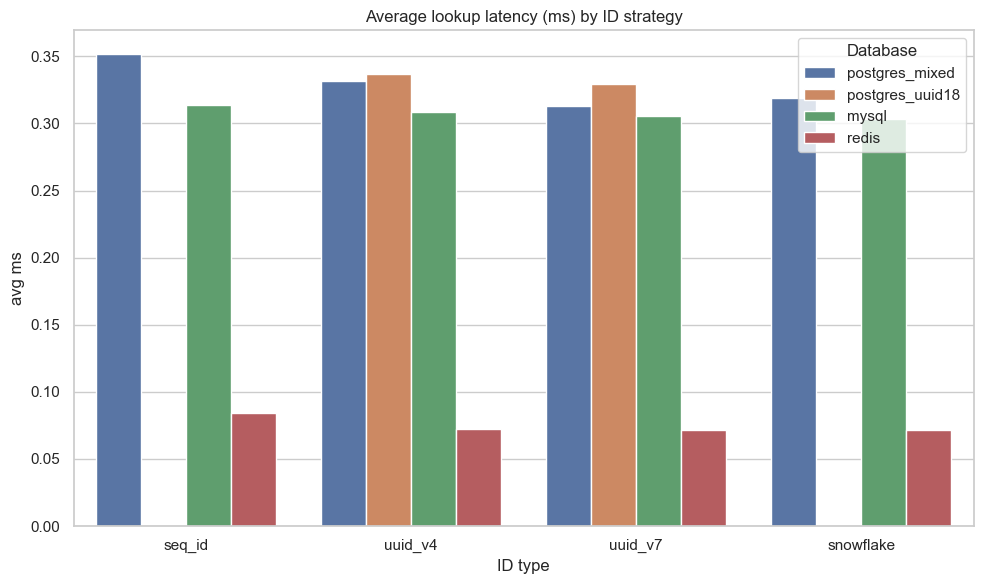

In [16]:
from plot_utils import bar_latency

bar_latency(lookup_df, metric='avg_ms', title='Average lookup latency (ms) by ID strategy')
plt.show()

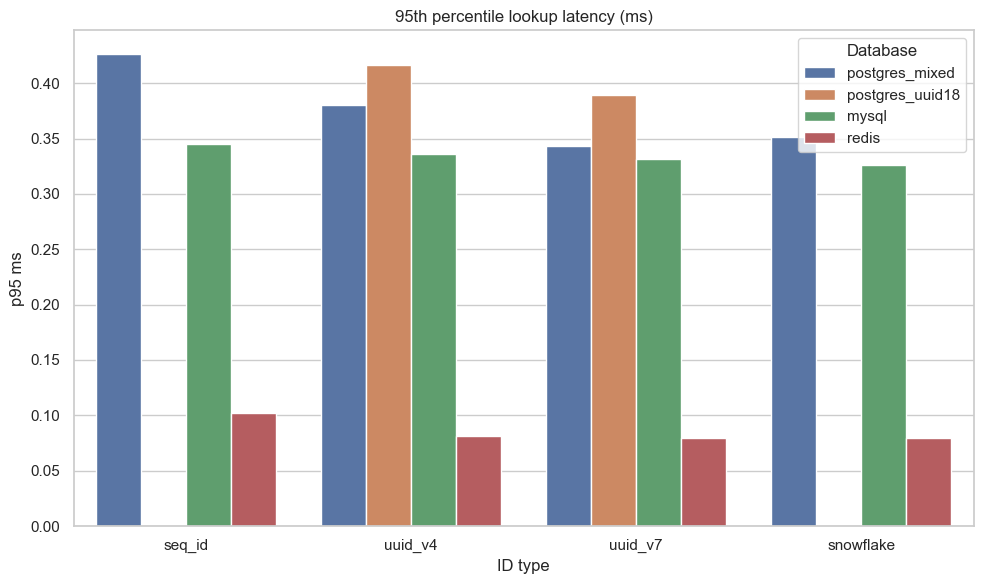

In [17]:
from plot_utils import bar_latency

bar_latency(lookup_df, metric='p95_ms', title='95th percentile lookup latency (ms)')
plt.show()